<a href="https://colab.research.google.com/github/seyed-mohammadreza-mousavi/ml-playground-starter/blob/main/KMeans_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# K-Means Clustering — Math, Implementation, and Visualization

**Author:** Generated by ChatGPT  
**Date:** 2025-10-09 13:22

This notebook is a complete, practical guide to K-Means clustering. It covers:
- The math behind K-Means (objective, derivations, convergence)
- A from-scratch NumPy implementation (including k-means++)
- Usage with `scikit-learn`
- How to choose *k* (Elbow, Silhouette)
- Preprocessing (scaling), dimensionality reduction (PCA) for visualization
- Real and synthetic datasets (Iris, blobs, moons)
- Strengths, limitations, and practical tips

> All plots are made with **matplotlib** (no seaborn). Each chart is on its own figure.



## 1. Math Background

## 1.1 Problem Setup
Given data points
$$
X = \{x_1, x_2, \dots, x_n\} \subset \mathbb{R}^d
$$
and an integer \(k\), K-Means seeks cluster assignments  
$$(c_i \in \{1, \dots, k\})$$ and centroids  
$$(\mu_1, \dots, \mu_k \in \mathbb{R}^d)$$  
that minimize the within-cluster sum of squares (WCSS):

$$
J(\{\mu_j\}, \{c_i\}) = \sum_{i=1}^{n} \lVert x_i - \mu_{c_i}\rVert_2^2
$$

---

## 1.2 Alternating Minimization
K-Means performs **coordinate descent** (also known as *Lloyd’s algorithm*):

**Assignment step (E-step):**  
With fixed centroids, assign each point to the nearest centroid:

$$[
c_i \leftarrow \arg\min_{j \in \{1,\dots,k\}} \lVert x_i - \mu_j\rVert_2^2.
]$$

**Update step (M-step):**  
With fixed assignments, update each centroid as the mean of its assigned points:
$$[
\mu_j \leftarrow \frac{1}{|C_j|} \sum_{i: c_i = j} x_i,
\quad C_j = \{ i \mid c_i = j \}.
]$$

**Derivation of the centroid update:**  
For fixed assignments, the objective decomposes across clusters:
$$[
J = \sum_{j=1}^k \sum_{i \in C_j} \lVert x_i - \mu_j \rVert_2^2.
]$$
For a single cluster \(j\), minimize
$$[
f(\mu_j) = \sum_{i \in C_j} \lVert x_i - \mu_j \rVert_2^2
]$$
with respect to \(\mu_j\). Taking the derivative and setting it to zero:
$$[
\frac{\partial f}{\partial \mu_j} = \sum_{i \in C_j} 2(\mu_j - x_i)
= 2\left(|C_j|\mu_j - \sum_{i \in C_j} x_i\right) = 0
\quad \Rightarrow \quad
\mu_j = \frac{1}{|C_j|}\sum_{i \in C_j} x_i.
]$$

Thus, the centroid update is simply the **cluster mean**.

---

## 1.3 Convergence and Complexity
Each iteration of K-Means **does not increase** the objective \(J\);  
therefore, the algorithm converges to a **local minimum** (not necessarily global).

- **Complexity per iteration:**  
  \(O(nkd)\), where:
  - \(n\): number of data points  
  - \(k\): number of clusters  
  - \(d\): dimensionality  
  Computing distances costs \(O(nkd)\); updating centroids costs \(O(nd)\).

- **Initialization matters:**  
  Poor initialization may lead to suboptimal local minima.  
  *k-means++* is a widely used heuristic for better seeding.

---

## 1.4 Choosing \(k\)
- **Elbow method:**  
  Plot \(J(k)\) vs. \(k\) and look for the "elbow" point where improvement slows down.

- **Silhouette score:**  
  For sample \(i\), let \(a(i)\) be the mean intra-cluster distance and \(b(i)\) the mean nearest-cluster distance.  
  The silhouette coefficient is defined as:
  $$[
  s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))} \in [-1, 1].
  ]$$
  Higher scores indicate better clustering.

---

## 1.5 When K-Means Works / Fails
✅ **Works well** when:
- Clusters are spherical (isotropic)
- Similar size and density
- Low noise, well-separated groups

⚠️ **Fails or struggles** when:
- Clusters are non-convex (e.g., "two moons" data)
- Varying density or size
- High-dimensional, sparse data  
→ In such cases, consider **DBSCAN**, **Gaussian Mixture Models**, or **Spectral Clustering** instead.

In [1]:

# Imports used across the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(42)
print("Versions: numpy", np.__version__)


Versions: numpy 2.0.2



## 2. From-Scratch K-Means (NumPy)

Below is a simple, educational implementation of K-Means. It supports:
- random initialization or k-means++
- maximum iterations and tolerance-based early stopping
- returning inertia (WCSS) and labels


In [9]:

def pairwise_sq_dists(X, Y):
    """Compute squared Euclidean distances between each row of X and Y."""
    return np.sum((X[:, None, :] - Y[None, :, :]) ** 2, axis=2)

def init_centroids_random(X, k, rng=None):
    rng = np.random.default_rng(None if rng is None else rng)
    idx = rng.choice(X.shape[0], size=k, replace=False)
    return X[idx].copy()

def init_centroids_kmeans_plus_plus(X, k, rng):
    """Numerically stable K-Means++ initialization."""
    n = X.shape[0]
    centroids = [X[rng.integers(0, n)]]

    for _ in range(1, k):
        d2 = np.min(pairwise_sq_dists(X, np.array(centroids)), axis=1)
        # Clamp any tiny negatives due to rounding
        d2 = np.maximum(d2, 0.0)

        total = np.sum(d2)
        if total == 0 or not np.isfinite(total):
            # fallback: pick random if all distances zero or invalid
            centroids.append(X[rng.integers(0, n)])
            continue

        probs = d2 / total
        probs = np.maximum(probs, 0)  # ensure non-negative
        probs /= np.sum(probs)        # renormalize
        next_idx = rng.choice(n, p=probs)
        centroids.append(X[next_idx])

    return np.array(centroids)

def kmeans_numpy(X, k=3, init="random", max_iter=300, tol=1e-4, rng=None):
    """K-Means clustering implemented from scratch with stable init."""
    rng = np.random.default_rng(rng)
    n, d = X.shape

    # ---- Initialization ----
    if init == "random":
        centroids = X[rng.choice(n, k, replace=False)]
    elif init == "k-means++":
        centroids = init_centroids_kmeans_plus_plus(X, k, rng)
    else:
        raise ValueError("init must be 'random' or 'k-means++'")

    # ---- Iterative Optimization ----
    prev_inertia = None
    for i in range(max_iter):
        dists = pairwise_sq_dists(X, centroids)
        labels = np.argmin(dists, axis=1)

        # recompute centroids
        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                new_centroids[j] = np.mean(cluster_points, axis=0)
            else:
                # empty cluster → reinitialize randomly
                new_centroids[j] = X[rng.integers(0, n)]

        inertia = np.sum((X - centroids[labels]) ** 2)

        # check convergence
        if prev_inertia is not None and abs(prev_inertia - inertia) < tol * prev_inertia:
            return new_centroids, labels, inertia, i + 1

        centroids = new_centroids
        prev_inertia = inertia

    return centroids, labels, inertia, max_iter



## 3. Synthetic Data Demo (Blobs)

We create 2D Gaussian blobs and run both our NumPy K-Means and `scikit-learn`'s KMeans. We visualize the clusters and centroids.


NumPy K-Means -> inertia: 1400.091622495903 iterations: 3


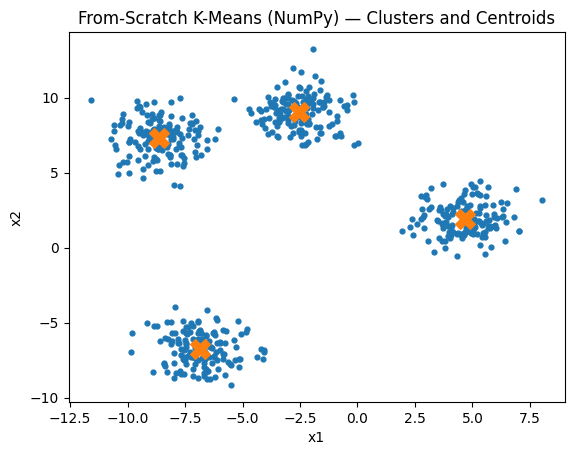

sklearn KMeans -> inertia: 1400.0916224959014 iterations: 2


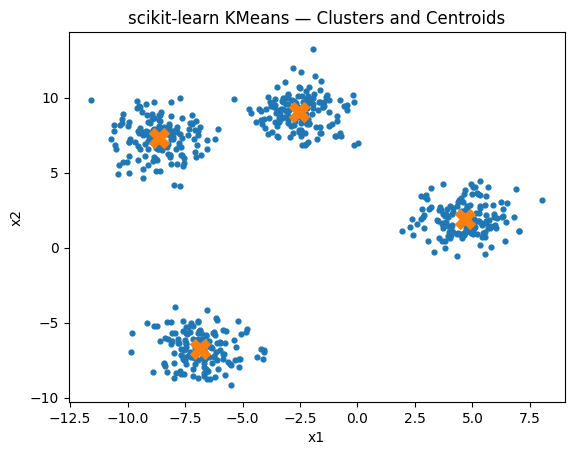

In [10]:

# Create synthetic blobs
X, y_true = make_blobs(n_samples=600, centers=4, cluster_std=1.10, random_state=42)

# Run our NumPy K-Means
C_np, labels_np, inertia_np, n_iter_np = kmeans_numpy(X, k=4, init="k-means++", max_iter=200, tol=1e-4, rng=42)
print("NumPy K-Means -> inertia:", inertia_np, "iterations:", n_iter_np)

# Plot result
plt.figure()
plt.scatter(X[:,0], X[:,1], s=12)
plt.scatter(C_np[:,0], C_np[:,1], marker="X", s=200)
plt.title("From-Scratch K-Means (NumPy) — Clusters and Centroids")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

# Compare with scikit-learn
km = KMeans(n_clusters=4, n_init=10, random_state=42, init="k-means++")
km.fit(X)
print("sklearn KMeans -> inertia:", km.inertia_, "iterations:", km.n_iter_)

plt.figure()
plt.scatter(X[:,0], X[:,1], s=12)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker="X", s=200)
plt.title("scikit-learn KMeans — Clusters and Centroids")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()



## 4. Choosing \(k\): Elbow and Silhouette

We compute WCSS (inertia) for a range of \(k\) values to plot an elbow curve, and compute the average silhouette score to gauge cluster separation quality.


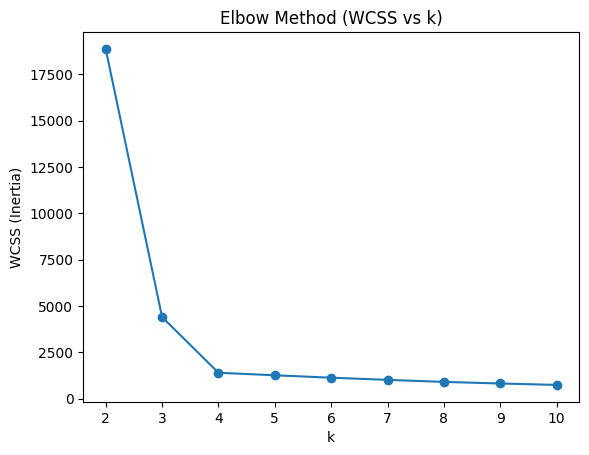

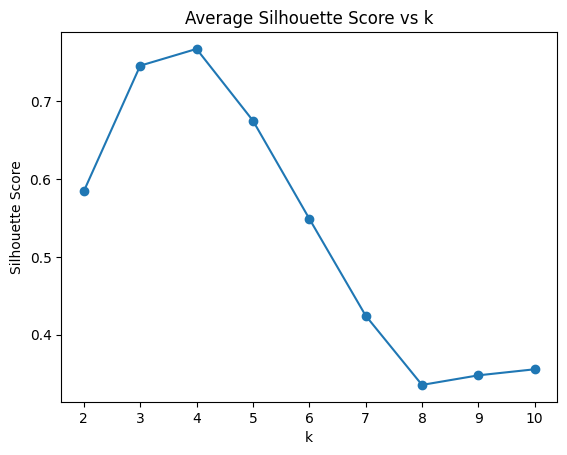

In [11]:

Ks = range(2, 11)
inertias = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42, init="k-means++")
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

# Elbow plot
plt.figure()
plt.plot(list(Ks), inertias, marker="o")
plt.title("Elbow Method (WCSS vs k)")
plt.xlabel("k"); plt.ylabel("WCSS (Inertia)")
plt.show()

# Silhouette plot
plt.figure()
plt.plot(list(Ks), sil_scores, marker="o")
plt.title("Average Silhouette Score vs k")
plt.xlabel("k"); plt.ylabel("Silhouette Score")
plt.show()



## 5. Preprocessing & 2D Visualization via PCA

Clustering often benefits from **feature scaling**. Here we scale features with `StandardScaler` and then reduce to 2D using `PCA` for visualization.


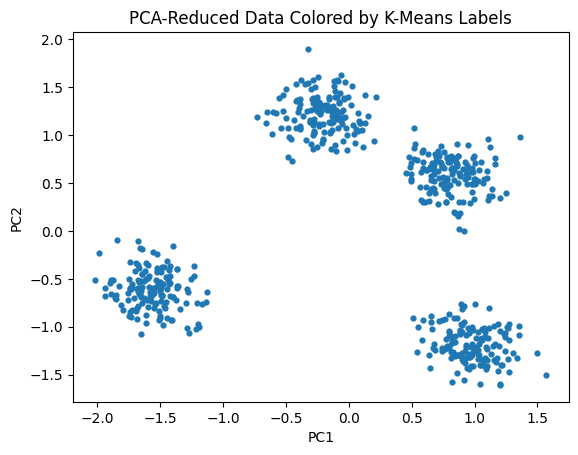

In [12]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

km = KMeans(n_clusters=4, n_init=10, random_state=42)
labels = km.fit_predict(X_pca)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], s=12)
plt.title("PCA-Reduced Data Colored by K-Means Labels")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()



## 6. Real Dataset: Iris

We cluster the classic Iris dataset into \(k=3\) clusters and visualize in PCA space, then compare cluster labels with true species (for reference only; K-Means is unsupervised).


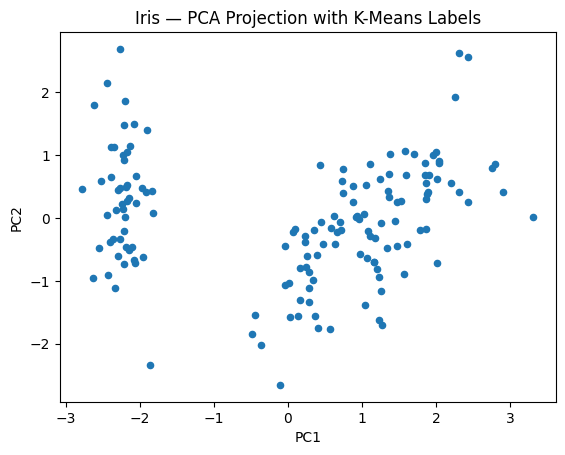

Iris silhouette score (k=3): 0.46


Cluster,0,1,2
True,,,
0,0,50,0
1,39,0,11
2,14,0,36


In [13]:

iris = load_iris()
X_iris = iris.data
species = iris.target

scaler_iris = StandardScaler()
X_iris_scaled = scaler_iris.fit_transform(X_iris)

pca_iris = PCA(n_components=2, random_state=42)
X_iris_pca = pca_iris.fit_transform(X_iris_scaled)

km_iris = KMeans(n_clusters=3, n_init=20, random_state=42, init="k-means++")
labels_iris = km_iris.fit_predict(X_iris_scaled)

plt.figure()
plt.scatter(X_iris_pca[:,0], X_iris_pca[:,1], s=20)
plt.title("Iris — PCA Projection with K-Means Labels")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# Quick evaluation via silhouette (unsupervised)
sil_iris = silhouette_score(X_iris_scaled, labels_iris)
print("Iris silhouette score (k=3):", round(sil_iris, 3))

# Optional: contingency table (unsupervised sanity-check)
import pandas as pd
df_ct = pd.crosstab(pd.Series(species, name="True"), pd.Series(labels_iris, name="Cluster"))
df_ct



## 7. Failure Case: Non-Convex Shapes (Two Moons)

K-Means assumes roughly spherical clusters. On a **two moons** dataset, it struggles to separate the shapes, unlike density-based alternatives. This section demonstrates the limitation.


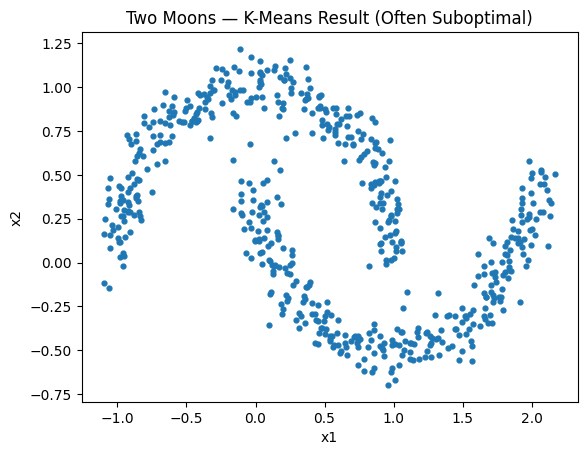

Silhouette score (moons, k=2): 0.489


In [14]:

X_moons, y_moons = make_moons(n_samples=600, noise=0.08, random_state=42)

km_moons = KMeans(n_clusters=2, n_init=10, random_state=42)
labels_moons = km_moons.fit_predict(X_moons)

plt.figure()
plt.scatter(X_moons[:,0], X_moons[:,1], s=12)
plt.title("Two Moons — K-Means Result (Often Suboptimal)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

print("Silhouette score (moons, k=2):", round(silhouette_score(X_moons, labels_moons), 3))



## 8. Practical Tips

- **Scale features** when dimensions have different units/magnitudes.  
- Use **k-means++** initialization and **multiple restarts** (`n_init`) to reduce sensitivity to initialization.  
- Run **Elbow** and **Silhouette** to guide your choice of \(k\).  
- Consider **PCA** (or other DR) to mitigate noise and to visualize high-dimensional data.  
- Beware of **outliers**: K-Means uses squared distances, so outliers can distort centroids.  
- If your data has **non-convex** or **varying-density** clusters, consider DBSCAN or spectral clustering instead.



## 9. Appendix: K-Means Pseudocode

```
Input: data X ∈ ℝ^{n×d}, number of clusters k
Initialize centroids μ₁,…,μ_k  (e.g., k-means++)

Repeat until convergence or max_iter:
    # Assignment
    For i = 1..n:
        c_i ← argmin_j ||x_i − μ_j||²

    # Update
    For j = 1..k:
        μ_j ← mean({ x_i : c_i = j })
Output: centroids {μ_j}, labels {c_i}, inertia J = ∑_i ||x_i − μ_{c_i}||²
```
